# Exploratory Data Analysis of AirBnB Listings in London, England
## Part 2 - Data Analysis Strategy
#### This section will focus in displaying information obtained from analyzing the influence of certain variables over others, determining or debunking potential relationships between them, and drawing conclusions from these analyses.

## Initial setup
### Run this section first to ensure the correct functionality of the rest of the script.

First, import the required libraries and set the maximum display of data tables

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

from matplotlib.ticker import PercentFormatter

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)


Then, import the corresponding datasets

In [9]:
lsts_url = "./data/listings.csv.gz"
revs_url = "./data/reviews.csv.gz"

lsts_df = pd.read_csv(lsts_url)
revs_df = pd.read_csv(revs_url)

### 2.1 Scores by category
First, we display a heatmap that shows the level of correlation between the different categories that guests are allowed to rate at the end of their stay.

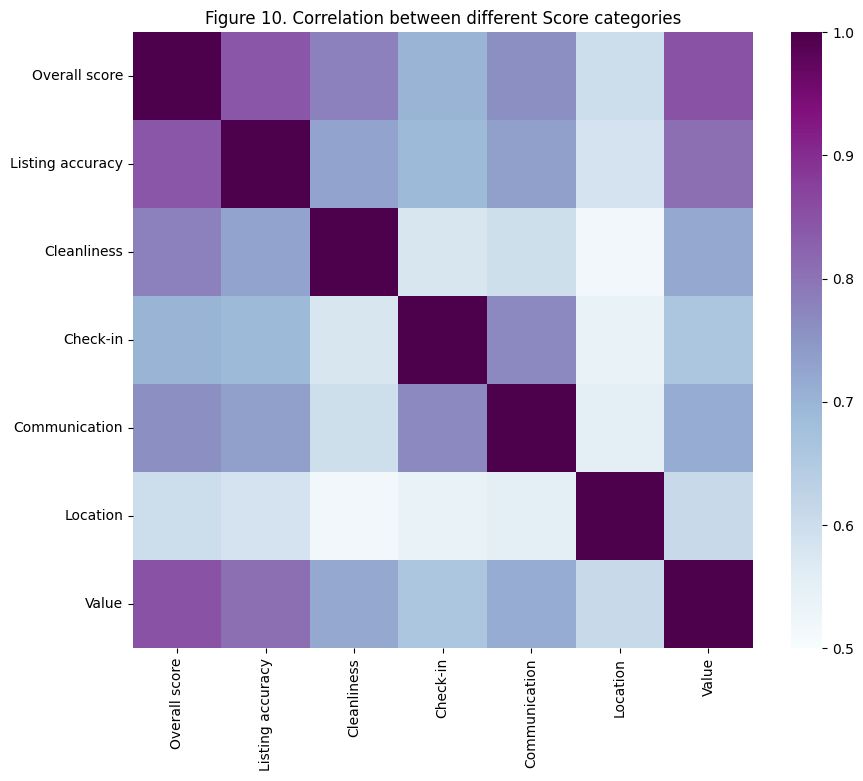

In [10]:
lsts_srn = lsts_df.rename(columns={"review_scores_rating":"Overall score","review_scores_accuracy":"Listing accuracy", \
                                   "review_scores_cleanliness":"Cleanliness","review_scores_checkin":"Check-in","review_scores_communication":"Communication", \
                                    "review_scores_location":"Location","review_scores_value":"Value"})

plt.figure(figsize=(10, 8))
sb.heatmap(lsts_srn[["Overall score", "Listing accuracy", "Cleanliness", "Check-in", "Communication", "Location", "Value"]].corr(), vmin=0.5, vmax=1, cmap="BuPu")
plt.title("Figure 10. Correlation between different Score categories")
plt.show()

The darker the color, the higher the correlation between the scores. Besides the diagonal (see note below), the score categories with the highest correlation to the overall scores are the Value, defined as how much does the guest believes the listing was worth the price they paid, and the accuracy of the listing's description and pictures.

**NOTE: The diagonal is the darkest color, since it represents the correlation of a variable with itself, and this will always be equal to 1.**

### <u>Conclusion #1: Clients will react better to accurate listings that make them feel their money was well spent, either by charging lesser fees or providing better listings.</u>

### 2.2 Price correlations
Now, let's take a look at possible variables that may be correlated to the price of listings in the most relevant neighbourhoods.

- Number of listings per neighbourhood
- Average 30-, 60-, and 90-day availability per neighbourhood
- Amenity score per neighbourhood

In [11]:
nh_cfreq = lsts_df["neighbourhood_cleansed"].value_counts(normalize=True).cumsum()                                      #Define variables that need to be carried over from notebook 01.
nh_rep = nh_cfreq.loc[nh_cfreq < 0.8].index.tolist()    

lsts_df["price_conv"] = lsts_df["price"].str.replace('[$,]','',regex=True).astype(float)                                #Redo the price conversion from a string to an operable number.

lsts_df['amenities'] = lsts_df['amenities'].str.strip('[]').str.split(", ")                                             #Recalculate the amenity score and add it to the dataframe.
amt_flt = pd.Series([x for item in lsts_df.amenities for x in item]).value_counts()[0:29]
lsts_df['amenity score'] = 0

for l in range(len(lsts_df)):
    lst_count = 0
    for a in lsts_df['amenities'][l]:
        if a in amt_flt:
            lst_count= lst_count+1
    lsts_df.at[l,'amenity score'] = lst_count


lsts_asc = lsts_df.groupby('neighbourhood_cleansed')['amenity score'].mean()
lsts_asr = lsts_asc.filter(items=nh_rep)

prc_corr = pd.DataFrame(nh_rep,columns=["Boroughs"])                                                                    #Create the new dataframe that will be used to calculate correlations
prc_corr['# of listings'] = 0
prc_corr['30-day availability'] = 0
prc_corr['60-day availability'] = 0
prc_corr['90-day availability'] = 0
prc_corr['Avg. amenity score'] = 0
prc_corr['Avg. price'] = 0

for l in prc_corr['Boroughs']:
    prc_corr.loc[prc_corr['Boroughs'] == l,'Avg. price'] = lsts_df.loc[lsts_df['neighbourhood_cleansed']==l,'price_conv'].mean()
    prc_corr.loc[prc_corr['Boroughs'] == l,'# of listings'] = len(lsts_df[lsts_df['neighbourhood_cleansed']==l])
    prc_corr.loc[prc_corr['Boroughs'] == l,'30-day availability'] = lsts_df.loc[lsts_df['neighbourhood_cleansed']==l,'availability_30'].mean()
    prc_corr.loc[prc_corr['Boroughs'] == l,'60-day availability'] = lsts_df.loc[lsts_df['neighbourhood_cleansed']==l,'availability_60'].mean()
    prc_corr.loc[prc_corr['Boroughs'] == l,'90-day availability'] = lsts_df.loc[lsts_df['neighbourhood_cleansed']==l,'availability_90'].mean()
    prc_corr.loc[prc_corr['Boroughs'] == l,'Avg. amenity score'] = lsts_asr[l]

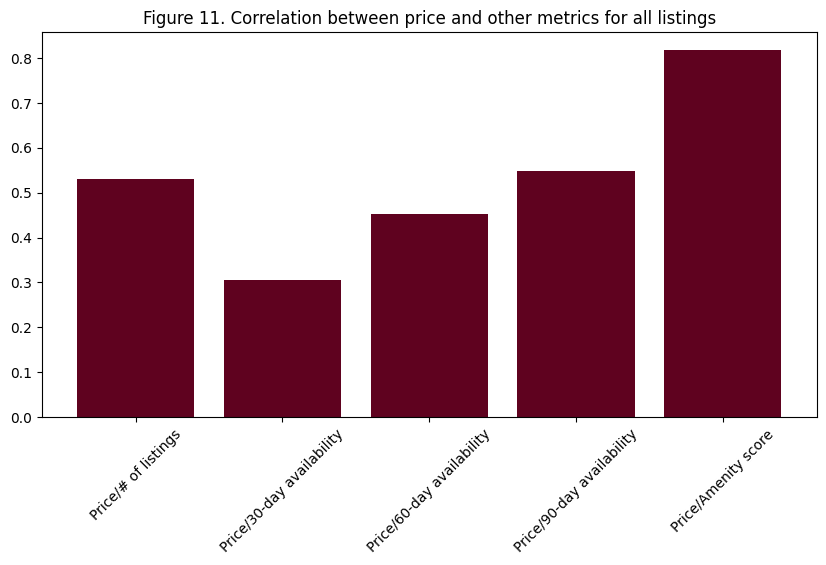

In [12]:
prc_lst_corr = prc_corr['Avg. price'].corr(prc_corr['# of listings'])
prc_30d_corr = prc_corr['Avg. price'].corr(prc_corr['30-day availability'])
prc_60d_corr = prc_corr['Avg. price'].corr(prc_corr['60-day availability'])
prc_90d_corr = prc_corr['Avg. price'].corr(prc_corr['90-day availability'])
prc_ams_corr = prc_corr['Avg. price'].corr(prc_corr['Avg. amenity score'])

x_values = ['Price/# of listings','Price/30-day availability','Price/60-day availability','Price/90-day availability','Price/Amenity score']
y_values = [prc_lst_corr,prc_30d_corr,prc_60d_corr,prc_90d_corr,prc_ams_corr]

plt.figure(figsize=(10,5))
plt.bar(x_values,y_values,color='#5f021f')
plt.xticks(rotation=45)
plt.title("Figure 11. Correlation between price and other metrics for all listings")
plt.show()

Out of these metrics, it is clear that the calculated amenity score has the strongest correlation to the average price of listings in each neighbourhood. This means that a small investment in providing better amenities in a property is likely to justify an increase in price, which can bring in more profit.

### <u>Conclusion #2: There is a correlation between listing price and the available amenities. Investing in amenities is likely to justify an increase in listing price.</u>

### 2.3 Average earnings per neighbourhood + potential earnings per availability

Lastly, we will calculate an approximate of the average earnings for each of the most relevant neighbourhoods using the number of reviews submitted during the last compelte year (2022) as a proxy for the number of times the listings of each neighbourhood were booked in the same timeframe.

With this proxy, we will calculate the average earnings for each borough.

In [17]:
lsts_id = lsts_df.rename(columns={'id':'listing_id'})                                           #Define variables that need to be carried over from notebook 01.
lsts_id = lsts_id[['listing_id','neighbourhood_cleansed']]
revs_nh = revs_df.merge(lsts_id,how="left")
revs_nh = revs_df.merge(lsts_id,how="left")
revs_nh[['date_year','date_month','date_day']] = revs_nh.date.str.split("-",expand=True)

lsts_prc = lsts_df.rename(columns={'id':'listing_id'})
lsts_prc = lsts_prc[["listing_id","neighbourhood_cleansed","price_conv"]]

revs_prc_fyr = revs_nh.loc[revs_nh['date_year']=='2022']
revs_prc = pd.merge(revs_prc_fyr,lsts_prc,on='listing_id',how='left')

revs_prc_avg = revs_prc.groupby('neighbourhood_cleansed_x')['price_conv'].mean()
revs_prc_avg = revs_prc_avg[revs_prc_avg.index.isin(nh_rep)]
revs_prc_avg = revs_prc_avg.sort_values(ascending=False)

lsts_rep = lsts_df.groupby('neighbourhood_cleansed')["id"].count()
lsts_rep = lsts_rep[lsts_rep.index.isin(nh_rep)]
lsts_rep = lsts_rep.sort_values(ascending=False)

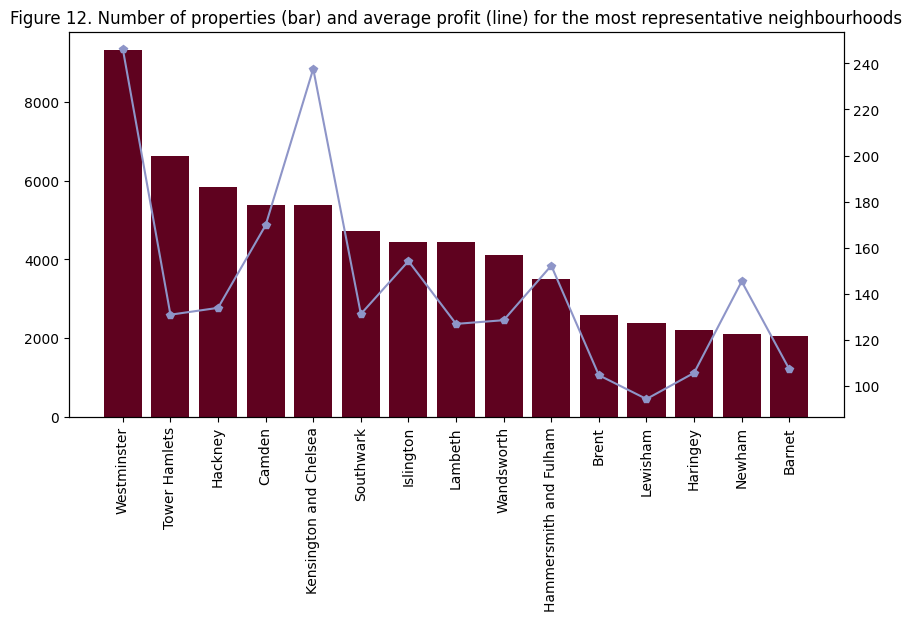

In [18]:
lsts_revs_prc = pd.concat([lsts_rep,revs_prc_avg],axis=1)
lsts_revs_prc = lsts_revs_prc.rename(columns={'id':'total_listings'})

plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
plt.bar(lsts_revs_prc.index,lsts_revs_prc['total_listings'],color="#5f021f")

plt2 = plt.twinx()
plt2.plot(lsts_revs_prc.index,lsts_revs_prc['price_conv'],color='#8e95c8',marker="p")

plt.title("Figure 12. Number of properties (bar) and average profit (line) for the most representative neighbourhoods")
plt.show()

As we can see, boroughs like Kelsington and Chelsea offer a smaller number of listings, but at a much higher average price. This may point towards a better opportunity to increase profit with a reduction in investment, but can also point to a specific borough being too expensive, which may reduce demand for listings in it.

### <u>Conclusion #3: Some boroughs show a much higher average earning despite having lesser listings available, which would not be advisable since it may be an indicator of an expensive borough that may not attract higher demand.</u>